In [1]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt

from analysis import load_events, filter_events

In [2]:
events = load_events("../../data/2024-11-19_08-38-28-extracted/logs_2024-11-20_09-36-12_236662-anthropoglot.txt")

Start time: 1732087935.3104022


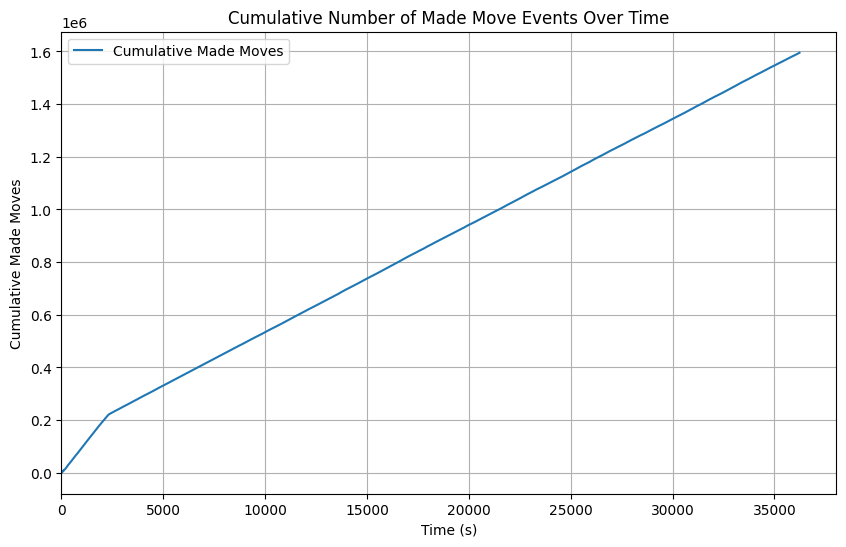

Time to first move: 11.155416011810303


In [3]:
timestamps = [event[0] for event in events if event[1] == "made_move"]
cumulative_made_moves = list(range(1, len(timestamps) + 1))

plt.figure(figsize=(10, 6))
plt.plot(timestamps, cumulative_made_moves, label='Cumulative Made Moves')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Made Moves')
plt.title('Cumulative Number of Made Move Events Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()

print(f"Time to first move: {min(timestamps)}")

In [4]:
print("Number of moves", max(cumulative_made_moves))

Number of moves 1595250


In [6]:
# What percent of time is the GPU thread being used?

total_duration = 0
total_evaluated = 0
for event in events:
    if event[1] == "gpu_evaluation":
        total_duration += event[2]["duration"]
        total_evaluated += event[2]["batch_size"]

evaluations = [event[0] for event in events if event[1] == "gpu_evaluation"]
print("percent GPU utilization:", total_duration / (max(evaluations) - min(evaluations)))

percent GPU utilization: 0.9224513997073467


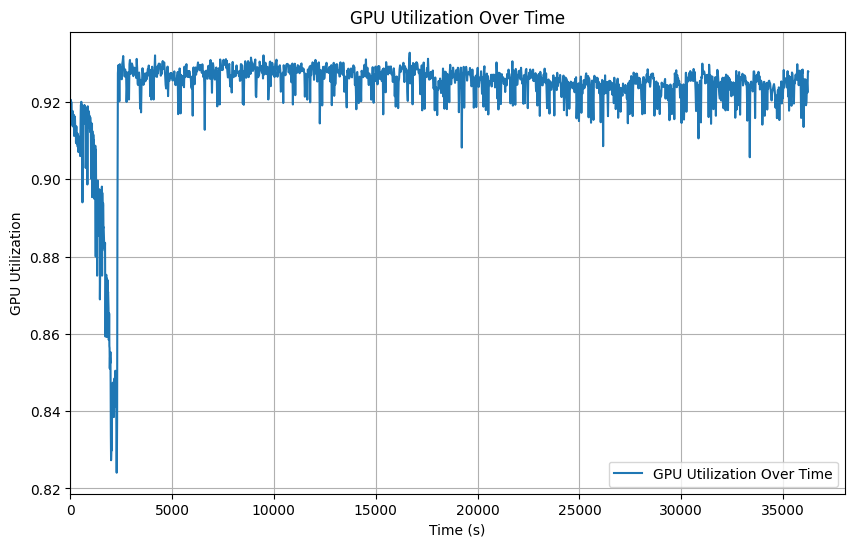

In [7]:
evaluations = [event for event in events if event[1] == "gpu_evaluation"]

gpu_utilization = []
times = []

window_size = 1000

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    time_interval = evaluations_in_window[-1][0] - evaluations_in_window[0][0]
    duration = sum(event[2]["duration"] for event in evaluations_in_window)

    gpu_utilization.append(duration / time_interval)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.plot(times, gpu_utilization, label='GPU Utilization Over Time')
plt.xlabel('Time (s)')
plt.ylabel('GPU Utilization')
plt.title('GPU Utilization Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()
